## ML competition

_Marilyn, Shiva, Olivier_

In [2]:
# Setup chunk
import time

# Data wrangling
import pandas as pd
import numpy as np

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Text sanitization
import re
import nltk
from nltk.stem.snowball import SnowballStemmer
stopwords = nltk.corpus.stopwords.words("english")
stemmer = SnowballStemmer(language="english")

# Lang detection
import langid
from langid.langid import LanguageIdentifier, model
identifier = LanguageIdentifier.from_modelstring(model, norm_probs=True)

# Misc
from tqdm import tqdm
tqdm.pandas()

# Define the seed for reproducibility
SEED = 31415

In [25]:
# Scikit time
from sklearn.naive_bayes import MultinomialNB, ComplementNB, BernoulliNB
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import (
    LinearDiscriminantAnalysis,
    QuadraticDiscriminantAnalysis,
)

from sklearn.feature_extraction.text import (
    CountVectorizer, 
    TfidfTransformer, 
    TfidfVectorizer
)
from sklearn.pipeline import Pipeline, make_pipeline


from sklearn.model_selection import (
    train_test_split, 
    GridSearchCV, 
    KFold, 
    cross_val_score
)

from sklearn.metrics import (
    classification_report, 
    accuracy_score, 
    confusion_matrix
)

In [4]:
df = pd.read_csv("data/MLUnige2021_train.csv")

### 1. EDA
Small EDA to check a bit the data

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1280000 entries, 0 to 1279999
Data columns (total 7 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   Id         1280000 non-null  int64 
 1   emotion    1280000 non-null  int64 
 2   tweet_id   1280000 non-null  int64 
 3   date       1280000 non-null  object
 4   lyx_query  1280000 non-null  object
 5   user       1280000 non-null  object
 6   text       1280000 non-null  object
dtypes: int64(3), object(4)
memory usage: 68.4+ MB


More than a million entries. What is `lyx_query`? 

In [8]:
df["lyx_query"].head()
df["lyx_query"].unique()

array(['NO_QUERY'], dtype=object)

Welp only `"NO_QUERY"` so we can drop it. 

In [9]:
df["tweet_id"]

0          2063391019
1          2000525676
2          2218180611
3          2190269101
4          2069249490
              ...    
1279995    1835296397
1279996    2226720395
1279997    1962176213
1279998    1976894947
1279999    1563596981
Name: tweet_id, Length: 1280000, dtype: int64

Those are old tweets

In [10]:
df["date"]

0          Sun Jun 07 02:28:13 PDT 2009
1          Mon Jun 01 22:18:53 PDT 2009
2          Wed Jun 17 22:01:38 PDT 2009
3          Tue Jun 16 02:14:47 PDT 2009
4          Sun Jun 07 15:31:58 PDT 2009
                       ...             
1279995    Mon May 18 05:39:18 PDT 2009
1279996    Thu Jun 18 12:18:05 PDT 2009
1279997    Fri May 29 10:38:30 PDT 2009
1279998    Sat May 30 19:28:13 PDT 2009
1279999    Sun Apr 19 23:27:25 PDT 2009
Name: date, Length: 1280000, dtype: object

Indeed they are.

In [11]:
len(df["user"].unique())

574114

Lots of different users. If we had only like 1000s of users, we could have looked for some pattern (user X is only positive ...).

In [12]:
df.loc[0, ["emotion", "text"]]

emotion                                                    1
text       @BreeMe more time to play with you BlackBerry ...
Name: 0, dtype: object

In [13]:
df["emotion"].unique()

array([1, 0], dtype=int64)

In [14]:
df[df["emotion"]==1].shape[0] - df[df["emotion"]==0].shape[0]

236

Perfectly balanced dataset (236 diff between the 2 classes).

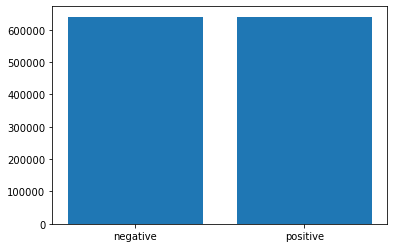

In [15]:
fig, ax = plt.subplots()
ax.bar(["negative", "positive"], [df[df["emotion"]==0].shape[0], df[df["emotion"]==1].shape[0]])
plt.show()

Let's also check the language of the tweets (all eng or also others?). For that, 

In [19]:
def lang_detect(txt, threshold=0.95):
    """
    Detect tweet language
    returns None if confidence lvl < threshold
    """

    if txt is None:
        return None

    txt = txt.replace("\n", " ")
    lang = identifier.classify(txt)
    if lang[1] < threshold:
        return None
    else:
        return lang[0]


In [24]:
df_samp = df.sample(150_000) #Total df takes 1h to run
#df_samp["lang"] = df_samp["text"].progress_apply(lang_detect)
#df_samp["lang"].unique()
#df_samp[~(df_samp["lang"] == "en")].count()

Only 15k tweets which are not detected as english in our 150k sample. By checking some of the tweets, most are english, but the language detector surely has some trouble with some very short tweets containing one or more foreign words.--> consider all as english!

## 2. Strategy

1. Preprocess the text
    1. remove punctuation marks
    2. remove stopwords (en)
    3. stem or lemmatize the words
    
    
2. take a sample of our whole dataset (200k?) to do our preliminary test. We can't do cross validation on the whole dataset.

3. Begin to fit the models. 
    1. Pipeline with TfidfTransformer (or the other one I don't remember the name)
    2. BerNB
    3. LogisticRegression
    4. RidgeClassifier
    5. SGDClassifier
    6. SVC
    7. RandomForestClassifier
    8. DecisionTreeClassifier
    9. KNeighborsClassifier
    10. LDA? QDA?
4. Select a few of the best models, CV with bigger dataset
5. ...

## Misc

- Should pay attention to some special chars which were not removed: "I \&lt;3 you" (#2204), at first just remove it, but we could try investigate that

# 1. Preprocessing

In [45]:
def sanitize(text: str) -> str:
    """Sanitize a string."""
    
    # Edited regex from @gruber
    # https://gist.github.com/gruber/8891611
    url_re = r"""(?i)\b((?:https?:(?:/{1,3}|[a-z0-9%])|[a-z0-9.\-]+[.](?:com|net|org|edu|gov)/)(?:[^\s()<>{}\[\]]+|\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\))+(?:\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’])|(?:(?<!@)[a-z0-9]+(?:[.\-][a-z0-9]+)*[.](?:com|net|org|edu|gov)\b/?(?!@)))"""
    
    edited_text = re.sub(
        "  ", " ", text
    )  # replace double whitespace with single whitespace
    edited_text = re.sub("@(?=.*\w)[\w]{1,15}", "", edited_text) # remove twitter handle
    edited_text = re.sub(
        url_re, "", edited_text
    )  # remove URL
    edited_text = edited_text.split(" ")  # split the sentence into array of strs
    edited_text = " ".join(
        [char for char in edited_text if char != ""]
    )  # remove any empty str from text
    edited_text = edited_text.lower()  # lowercase
    edited_text = re.sub("\d+", "", edited_text)  # Removing numerics
    edited_text = re.split(
        "\W+", edited_text
    )  # spliting based on whitespace or whitespaces
    edited_text = " ".join(
        [stemmer.stem(word) for word in edited_text if word not in stopwords]
    )  # Snowball Stemmer
    
    return edited_text

# Some special strings to test 
txt1 = "Hello @Shiva and @Marilyn!"
#print("Sanitized:", sanitize(txt1))
regex = "@(?=.*\w)[\w]{1,15}"
#print(re.sub(regex, "", txt1))

# As a test, sanitize the subsample
df_samp["sanitized"] = df_samp["text"].progress_apply(sanitize)

100%|████████████████████████████████████████████████████████████████████████| 150000/150000 [00:17<00:00, 8613.29it/s]


In [46]:
df_samp.head() #seems good

,Id,emotion,tweet_id,date,lyx_query,user,text,sanitized
747649,747649,1,1970462059,Sat May 30 03:58:00 PDT 2009,NO_QUERY,AilidhDocherty,Chilling in the sun.. Although I feel my face ...,chill sun although feel face get burnt
525499,525499,0,1556216852,Sat Apr 18 22:02:04 PDT 2009,NO_QUERY,shutupmeg,(@MatAshton) I'm having violent feelings towar...,violent feel toward bird outsid window shut w...
956297,956297,1,2057569623,Sat Jun 06 13:14:55 PDT 2009,NO_QUERY,tweeteradder10,@armybrat4life1 Get 100 followers a day using ...,get follow day use add everyon train pay vip
81013,81013,1,2056860638,Sat Jun 06 11:55:58 PDT 2009,NO_QUERY,Brennon_Pratt,Headed out to deposit some checks and stop by ...,head deposit check stop walmart get airsoft gu...
408310,408310,1,1932816756,Tue May 26 22:17:16 PDT 2009,NO_QUERY,eeelz,@suloshini Happy thoughts! Your mum is going t...,happi thought mum go fine


In [5]:
try:
    df_san = pd.read_pickle("./data/sanitized.pkl")
except FileNotFoundError:
    print("No pickle file found, sanitizing existing df")
    
    # Sanitize whole dataset
    df["sanitized"] = df["text"].progress_apply(sanitize)

    # Export it to pickle so we don't have to redo it
    df.to_pickle("./data/sanitized.pkl")

In [7]:
print(df_san.shape)
df_san.head()

(1280000, 8)


,Id,emotion,tweet_id,date,lyx_query,user,text,sanitized
0,0,1,2063391019,Sun Jun 07 02:28:13 PDT 2009,NO_QUERY,BerryGurus,@BreeMe more time to play with you BlackBerry ...,time play blackberri
1,1,0,2000525676,Mon Jun 01 22:18:53 PDT 2009,NO_QUERY,peterlanoie,Failed attempt at booting to a flash drive. Th...,fail attempt boot flash drive fail attempt swi...
2,2,0,2218180611,Wed Jun 17 22:01:38 PDT 2009,NO_QUERY,will_tooker,@msproductions Well ain't that the truth. Wher...,well truth damn auto lock disabl go copi past ...
3,3,1,2190269101,Tue Jun 16 02:14:47 PDT 2009,NO_QUERY,sammutimer,@Meaghery cheers Craig - that was really sweet...,cheer craig realli sweet repli pump
4,4,0,2069249490,Sun Jun 07 15:31:58 PDT 2009,NO_QUERY,ohaijustin,I was reading the tweets that got send to me w...,read tweet got send lie phone face drop amp hi...


In [8]:
print("Before sanitizing", df['text'].apply(lambda x: len(x.split(' '))).sum())
print("After sanitizing", df_san['sanitized'].apply(lambda x: len(x.split(' '))).sum())

Before sanitizing 18398298
After sanitizing 9575942


Just to check, we see that before sanitizing, we had 18'398'298 words. We were able to halve it to 9'575'942 by sanitization and stemming our tweets.

Before fitting our models, we also take a subsample to be able to compute them faster.

In [13]:
df_sub = df_san.sample(frac=0.15, random_state=SEED)

# To check reproducibility
print("First Id", df_sub["Id"].iloc[0])
print("Last Id", df_sub["Id"].iloc[-1])
print("Length", df_sub.shape[0])

First Id 423388
Last Id 503594
Length 192000


# 2. Fitting

Now that we have a subsample (15%) of our cleaned data, we can try to fit some models to see what it gives us. We also define a standard 10 kfolds which we will use for our cross-validation. 

In [14]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(df_sub["sanitized"], df_sub["emotion"], 
                                                    test_size=0.2, shuffle=True, random_state=SEED)
folds = KFold(n_splits=10, shuffle=True, random_state=SEED)

In [15]:
# Sanity check
print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)
print("y_train: ", y_train.shape)
print("y_test: ", y_test.shape)

X_train:  (153600,)
X_test:  (38400,)
y_train:  (153600,)
y_test:  (38400,)


First model we will try is the `BernoulliNB` since we have binary data. 

In [26]:
berNB = Pipeline(
    [
        ("tfidf", TfidfVectorizer()),
        ("clf", BernoulliNB()),
    ]
)

start = time.time()

CV_ber = cross_val_score(
    berNB, X_train, y_train, scoring="accuracy", cv=folds, n_jobs=-1
)

berNB.fit(X_train, y_train)
y_pred = berNB.predict(X_test)
score = accuracy_score(y_test, y_pred)
print(f"Time {time.time() - start}")
print(f"Mean CV accuracy: {np.mean(CV_ber)}")
print(f"Test accuracy: {score}")

"""
Time 8.715646505355835
Mean CV accuracy: 0.7543294270833332
Test accuracy: 0.7544010416666667
"""

Time 7.663532018661499
Mean CV accuracy: 0.7543294270833332
Test accuracy: 0.7544010416666667


'\nTime 8.715646505355835\nMean CV accuracy: 0.7543294270833332\nTest accuracy: 0.7544010416666667\n'

Without any paramter tuning, we got 75% with the naive Bayes Bernoulli classifier.
Baseline is `0.77309`. 

In [37]:
berNB = Pipeline(
    [
        ("vect", CountVectorizer()),
        ("tfidf", TfidfTransformer()),
        ("clf", BernoulliNB()),
    ]
)

start = time.time()

gridsearch  = GridSearchCV(
    berNB,
    {
        "clf__alpha": np.linspace(1e-10, 5, 10),
        "clf__fit_prior": [False, True]
    },
    scoring="accuracy",
    n_jobs=-1
)

gridsearch.fit(X_train, y_train)
res = gridsearch.cv_results_
resdf = pd.DataFrame(res)
print(f"Time {time.time() - start}")
print(resdf[resdf["rank_test_score"] == 1])

Time 126.00729584693909
    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
18       1.008442      0.034566         0.211298        0.011747   

   param_clf__alpha param_clf__fit_prior  \
18              5.0                False   

                                          params  split0_test_score  \
18  {'clf__alpha': 5.0, 'clf__fit_prior': False}           0.757617   

    split1_test_score  split2_test_score  split3_test_score  \
18           0.756022           0.757682           0.755339   

    split4_test_score  mean_test_score  std_test_score  rank_test_score  
18           0.756966         0.756725        0.000915                1  


No matter the alpha, we don't seem to get higher than 0.75. BernoulliNB is not the best model here.
Instead of having to write the same for every model, let's try to automatize the testing just by specifying the model and the parameters grid.

In [75]:
models = [BernoulliNB(), LogisticRegression(warm_start=True)]
models = [LogisticRegression(warm_start=True)]

params_tfid = {
    "tfidfvectorizer__norm": ["l1", "l2"],
    #"tfidfvectorizer__use_idf": [True, False],
    #"tfidfvectorizer__smooth_idf": [True, False],
    #"tfidfvectorizer__sublinear_tf": [True, False]
}

params = {
    "bernoullinb": {
        "bernoullinb__alpha": np.linspace(1e-10, 10, 5),
        "bernoullinb__fit_prior": [False, True],
    },
    "logisticregression": {
        "logisticregression__penalty": ["l1", "l2", "elasticnet"],
        #"logisticregression__dual": [False, True], try with liblinear
        "logisticregression__C": 10**np.linspace(-3, 2, 6),
        "logisticregression__random_state": [SEED],
        #"logisticregression__solver": ["newton-cg", "lbfgs", "saga"],
        "logisticregression__solver": ["saga"],
        "logisticregression__l1_ratio": np.linspace(0, 1, 5),
    }
}

# If we also want to gridsearch the different Tfidf params
for k, v in params_tfid.items():
    params["bernoullinb"][k] = v
    #Easier if we comment above
    pass

pipes = []

# Also check what we can do with the TfidfVectorizer parameters
for model in models:
    pipe = make_pipeline(TfidfVectorizer(), model)
    pipes.append(pipe)
    
    # Will use that once we have the best params
    #pipe.set_params(**params[pipe.steps[1][0]])

# Initialize empty dictionary
reports = {}

In [ ]:
# Fit each different pipeline

for pipe in pipes:
    print("\n", pipe.steps[1][0])
    start = time.time()
    
    gridsearch = GridSearchCV(pipe, params[pipe.steps[1][0]], scoring="accuracy", cv=folds, n_jobs=-1, verbose=3)
    gridsearch.fit(X_train, y_train)
    y_pred = gridsearch.predict(X_test)
    
    score = accuracy_score(y_test, y_pred)
    resdf = pd.DataFrame(gridsearch.cv_results_)
    
    reports[pipe.steps[1][0]] = classification_report(y_test, y_pred)
    
    print(f"Time {time.time() - start}s")
    print(resdf[resdf["rank_test_score"] == 1])
    print(f"Test accuracy: {score}")
    


 logisticregression
Fitting 5 folds for each of 360 candidates, totalling 1800 fits


### Summary

BernoulliNB() - 0.76
    

In [53]:
reports

{'bernoullinb': '              precision    recall  f1-score   support\n\n           0       0.76      0.76      0.76     19173\n           1       0.76      0.76      0.76     19227\n\n    accuracy                           0.76     38400\n   macro avg       0.76      0.76      0.76     38400\nweighted avg       0.76      0.76      0.76     38400\n'}